In [2]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game, convert_obs
from notebooks.learning_agents.static_agents import random_approval_wolf, random_plurality_wolf
import notebooks.learning_agents.stats as indicators 

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Agent Implementation

We have implemented hand-crafted agents for both villager and werewolf roles, along with actor-critic models for villagers that were trained against hand-crafted werewolves. We based our static policies on the work done in past games implementing werewolf {cite}`Brandizzi2021RLupusCT, Lipinski2022EMP`. This was to have good baselines to compare our trained villagers with, and a reliable wolf strategy to train our villagers against.

## Villagers

### Hand-crafted Policies

#### Random Villagers 

There are three type of random villager policies we tested. The fully random, the one randomly targetting living players, and the coordinated random target (which was the strategy mentioned in {cite}`braverman2008mafia`). 

The truly random agent simply samples from the [action space](env-spaces).

```python
def random_agent_action(env, agent, action=None):
   return env.action_space(agent).sample().tolist()
```

The other random villagers either act independently, or coordinate on a random target via an action parameter. Approval agents act much the same way, selecting -1 for their target and liking themselves.

During each phase, each villager $v_i$ picks a random target out of remaining players at round $t$ excluding themselves $N_t \\ \{v_i\}$. Although agents act simultanously, the program loops sequentially through agents, so if agents are coordinating via an action parameter, then the first agents choice gets used by all subsequent villagers.

```python
def random_plurality_villager(env, agent, action=None):
    if action != None:
        return action

    targets = set(env.world_state["alive"]) - set([agent])
    return int(random.choice(list(targets)).split("_")[-1])

def random_approval_villager(env, agent, action=None):
    
    if action != None:
        return action
    
    targets = set(env.world_state["alive"]) - set([agent])
    action = [0] * len(env.possible_agents)
    action[int(agent.split("_")[-1])] = 1
    action[int(random.choice(list(targets)).split("_")[-1])] = -1

    return action
```

These random villagers, when coordinating or acting alone,

#### Behavioral Villagers

TODO if time allows.

These agents

### Learning Agents

#### Model Architecture
Determining the proper model architecture for Agents is not a straightforward task, and takes some experimentation. Initially we had gone with seperate networks for value and policy models, however, we settled on a shared network for both, inspired by a truncated BPTT implementation with PPO {cite}`pleines2023memory`. We treat agents as independent learners with a shared policy.

Models are  tied to the number of agents per game they were trained on, so a 5-player game environment agent will not work if fed observations from a 10-player game environment.

Most of the training and work was done in 10-player environments as it allowed for more interesting gameplay in a setting where no communication other than voting is allowed.

Below is our model architecture that is shared amongst plurality and approval agents and has trained villagers. The input tensors are the previous hidden states of the LSTM, and the flattened observations the agent receives from the environment. 

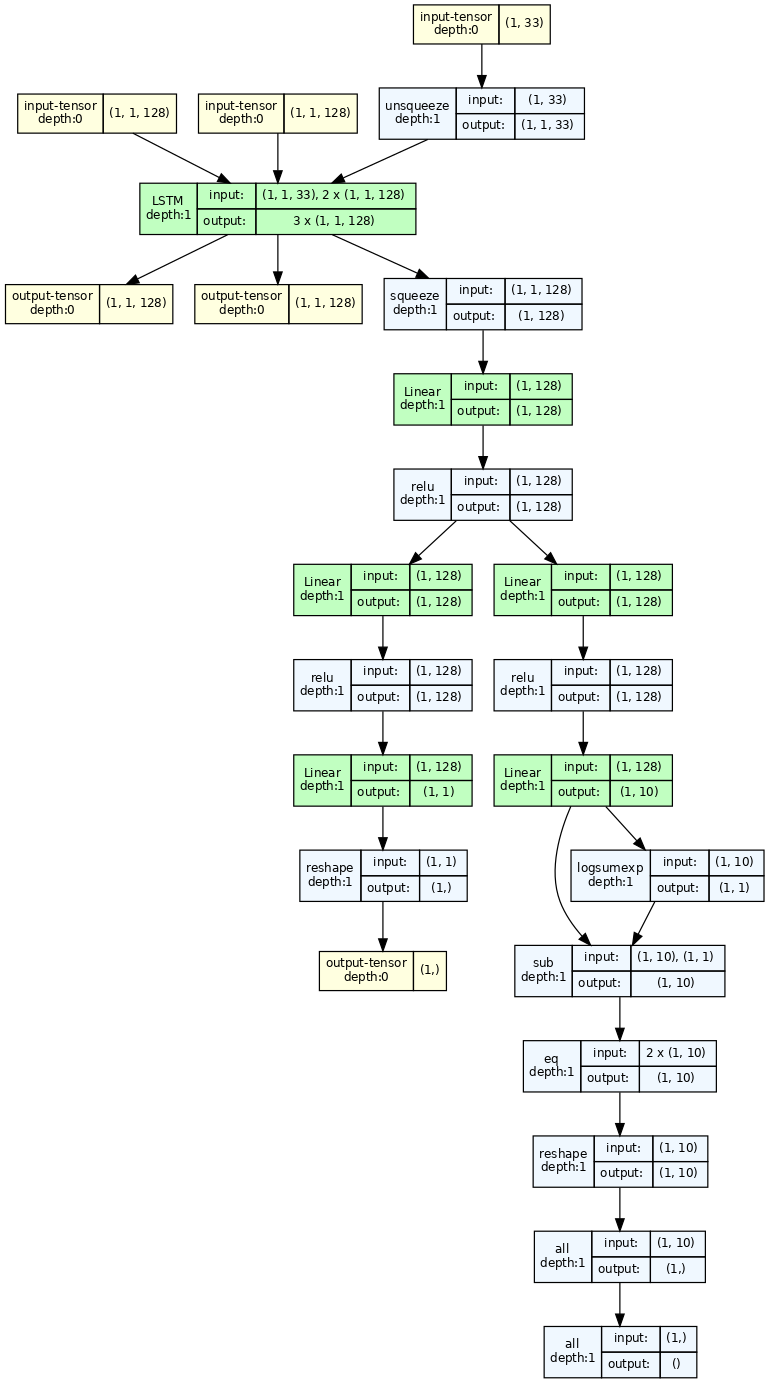

In [3]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

untrained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128, 
                                        "rec_layers": 1,
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

obs = convert_obs(observations['player_0']['observation'], voting_type='plurality')
obs = torch.unsqueeze(obs,0)
hxcs = (torch.zeros((1,1,128), dtype=torch.float32), torch.zeros((1,1,128), dtype=torch.float32))

model_graph = draw_graph(untrained_plurality_agent, input_data=[obs,hxcs], device=torch.device('cpu'))
model_graph.visual_graph

## Werewolves

Werewolf behavior for both plurality and approval environments used hand-crafted policies because the focus was on villager voting. These various wolf behaviors are reasonable and mimic other logical agents employed in AIWolf {cite}`toriumi2017ai` and RLupus {cite}`Brandizzi2021RLupusCT`. We had one random wolf function with a flag that either set the action for the next wolf if they were coordinating, or not, for truly random wolves.

```python
def random_plurality_wolf(env, agent, action=None):
    villagers_remaining = set(env.world_state["villagers"]) & set(env.world_state['alive'])
    return action if action != None else int(random.choice(list(villagers_remaining)).split("_")[-1])

def random_approval_wolf(env, agent, action=None):
    if action != None:
        return action

    villagers_remaining = set(env.world_state["villagers"]) & set(env.world_state['alive'])
    wolves_remaining = set(env.world_state["werewolves"]) & set(env.world_state['alive'])

    # pick a living target
    target = random.choice(list(villagers_remaining))

    action = [0] * len(env.possible_agents)
    action[int(target.split("_")[-1])] = -1
    for curr_wolf in wolves_remaining:
        action[int(curr_wolf.split("_")[-1])] = 1

    return action
```